# Adversarial Validation

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)
sns.set_theme(context="notebook", style="whitegrid")

## Config

In [2]:
# file paths
DATA_DIR = Path("../input/alvin-smart-money-classification-challenge")

# data
TRAIN_DATA = DATA_DIR / "train.csv"

TEST_DATA = DATA_DIR / "test.csv"

EXTRA_DATA = DATA_DIR / "extra_data.csv"

# columns in the data
INDEX_COL = "Transaction_ID"

TARGET_COL = "MERCHANT_CATEGORIZED_AS"

# random state
RANDOM_STATE = 98765

## Loading the data

In [3]:
dt_cols = ["MERCHANT_CATEGORIZED_AT", "PURCHASED_AT"]
train_df = pd.read_csv(TRAIN_DATA, index_col=INDEX_COL, parse_dates=dt_cols)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, ID_04mk78fa to ID_zztijwt3
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                373 non-null    datetime64[ns, UTC]
 1   MERCHANT_NAME                          373 non-null    object             
 2   MERCHANT_CATEGORIZED_AS                373 non-null    object             
 3   PURCHASE_VALUE                         373 non-null    int64              
 4   PURCHASED_AT                           373 non-null    datetime64[ns, UTC]
 5   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  373 non-null    bool               
 6   USER_AGE                               61 non-null     float64            
 7   USER_GENDER                            367 non-null    object             
 8   USER_HOUSEHOLD                         373 non-null    int64              
 9

In [4]:
test_df = pd.read_csv(TEST_DATA, index_col=INDEX_COL, parse_dates=dt_cols)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558 entries, ID_00x9h2yx to ID_zz7zds1s
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                558 non-null    datetime64[ns, UTC]
 1   MERCHANT_NAME                          558 non-null    object             
 2   PURCHASE_VALUE                         558 non-null    int64              
 3   PURCHASED_AT                           558 non-null    datetime64[ns, UTC]
 4   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  558 non-null    bool               
 5   USER_AGE                               85 non-null     float64            
 6   USER_GENDER                            553 non-null    object             
 7   USER_HOUSEHOLD                         558 non-null    int64              
 8   USER_INCOME                            558 non-null    int64              
 9

In [5]:
extra_df = pd.read_csv(EXTRA_DATA, index_col=INDEX_COL, parse_dates=dt_cols)
extra_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, ID_v13grrw3 to ID_cxhvhlnw
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   MERCHANT_CATEGORIZED_AT                0 non-null      datetime64[ns]     
 1   MERCHANT_NAME                          10000 non-null  object             
 2   MERCHANT_CATEGORIZED_AS                0 non-null      float64            
 3   PURCHASE_VALUE                         10000 non-null  int64              
 4   PURCHASED_AT                           10000 non-null  datetime64[ns, UTC]
 5   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  10000 non-null  bool               
 6   USER_AGE                               1158 non-null   float64            
 7   USER_GENDER                            9966 non-null   object             
 8   USER_HOUSEHOLD                         10000 non-null  int64              


## Preprocessing

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from lightgbm import LGBMClassifier

In [7]:
# helper functions
def featurize_ts(series: pd.Series) -> pd.DataFrame:
    """Extract features from a timestamp column"""
    df = pd.DataFrame()
    col_prefix = series.name
    df[f"{col_prefix}_month"] = series.dt.month
    df[f"{col_prefix}_day"] = series.dt.day
    df[f"{col_prefix}_weekday"] = series.dt.weekday
    df[f"{col_prefix}_hour"] = series.dt.hour
    return df


def log_transform(arr: np.ndarray) -> np.ndarray:
    return np.expand_dims(np.log(arr), axis=1)

In [8]:
untranformed_cols = ["IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY", "USER_HOUSEHOLD"]

encoder_pipe = Pipeline(
    [
        (
            "encode",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-999),
        ),
    ]
)
imputer_pipe = Pipeline(
    [
        ("expand_dims", FunctionTransformer(np.expand_dims, kw_args={"axis": 1})),
        ("impute", SimpleImputer(strategy="constant", fill_value=-999)),
    ]
)

col_trans = ColumnTransformer(
    [
        ("merch_name_vec", CountVectorizer(stop_words="english"), "MERCHANT_NAME"),
        # ("categorized_ts", FunctionTransformer(featurize_ts), "MERCHANT_CATEGORIZED_AT"),
        ("purchased_ts", FunctionTransformer(featurize_ts), "PURCHASED_AT"),
        ("identity", FunctionTransformer(lambda x: x * 1), untranformed_cols),
        ("log_purchase", FunctionTransformer(log_transform), "PURCHASE_VALUE"),
        ("log_income", FunctionTransformer(log_transform), "USER_INCOME"),
        ("encode", encoder_pipe, ["USER_ID", "USER_GENDER"]),
        ("impute_age", imputer_pipe, "USER_AGE"),
    ],
    n_jobs=-1,
)

In [9]:
from sklearn import set_config

set_config(display="diagram")
make_pipeline(col_trans, LGBMClassifier())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('merch_name_vec',
                                                  CountVectorizer(stop_words='english'),
                                                  'MERCHANT_NAME'),
                                                 ('purchased_ts',
                                                  FunctionTransformer(func=<function featurize_ts at 0x7f70f4e257a0>),
                                                  'PURCHASED_AT'),
                                                 ('identity',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f70f2740d40>),
                                                  ['IS_PURCHASE_PAID_VIA_MPESA...
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-999))]),
                                                  ['USER_ID', 'USER_GENDER']),
                                                 ('impute_age',
                                                  Pipeline(steps=[('expand_dims',
                                                                   FunctionTransformer(func=<function expand_dims at 0x7f71440155f0>,
                                                                                       kw_args={'axis': 1})),
                                                                  ('impute',
                                                                   SimpleImputer(fill_value=-999,
                                                                                 strategy='constant'))]),
                                                  'USER_AGE')])),
                ('lgbmclassifier', LGBMClassifier())])

## Train vs test

In [10]:
train_df = train_df.drop(TARGET_COL, axis=1)
TARGET_COL = "is_test"
train_df[TARGET_COL] = 0
test_df[TARGET_COL] = 1
df = pd.concat([train_df, test_df]).sample(frac=1)
df[TARGET_COL].value_counts()

1    558
0    373
Name: is_test, dtype: int64

In [11]:
y = df[TARGET_COL]
X = df.drop(TARGET_COL, axis=1)

pipe = make_pipeline(col_trans, LGBMClassifier())
cv_results = cross_val_score(pipe, X, y, scoring="roc_auc")
print(f"AUC scores: {cv_results}")
print("AUC mean:{}, std:{}".format(np.mean(cv_results), np.std(cv_results)))

AUC scores: [0.45821429 0.42217664 0.52962114 0.47303303 0.52294294]
AUC mean:0.48119760832260833, std:0.040412570533405356


## Train vs extra

In [12]:
train_df = train_df.drop(TARGET_COL, axis=1)
TARGET_COL = "is_extra"
train_df[TARGET_COL] = 0
extra_df[TARGET_COL] = 1
df = pd.concat([train_df, extra_df]).sample(frac=1)
df[TARGET_COL].value_counts()

1    10000
0      373
Name: is_extra, dtype: int64

In [13]:
y = df[TARGET_COL]
X = df.drop(TARGET_COL, axis=1)

pipe = make_pipeline(col_trans, LGBMClassifier())
cv_results = cross_val_score(pipe, X, y, scoring="roc_auc")
print(f"AUC scores: {cv_results}")
print("AUC mean:{}, std:{}".format(np.mean(cv_results), np.std(cv_results)))

AUC scores: [0.89665333 0.9421     0.92548667 0.96672297 0.93852703]
AUC mean:0.9338980000000001, std:0.02290892956665112


In [14]:
def get_col_names(pipe: Pipeline) -> list:
    """Get the column names of the feature matrix"""
    transformers = pipe.named_steps["columntransformer"].named_transformers_
    merchant_cols = list(transformers["merch_name_vec"].get_feature_names_out())
    ts_features = ("month", "day", "weekday", "hour")
    ts_cols = [f"purchased_{feat}" for feat in ts_features]
    other_cols = ["log_purchase", "log_income", "USER_ID", "USER_GENDER", "age"]
    return merchant_cols + ts_cols + untranformed_cols + other_cols

In [15]:
pipe.fit(X, y)
feature_importance = pd.Series(
    pipe.named_steps["lgbmclassifier"].feature_importances_, get_col_names(pipe)
)
important = feature_importance[feature_importance > 0]
important = important.sort_values(ascending=False)
important

log_purchase       481
purchased_day      329
purchased_hour     289
purchased_month    287
USER_ID            189
                  ... 
ngong                1
capital              1
op                   1
paytech              1
tunukiwa             1
Length: 137, dtype: int32

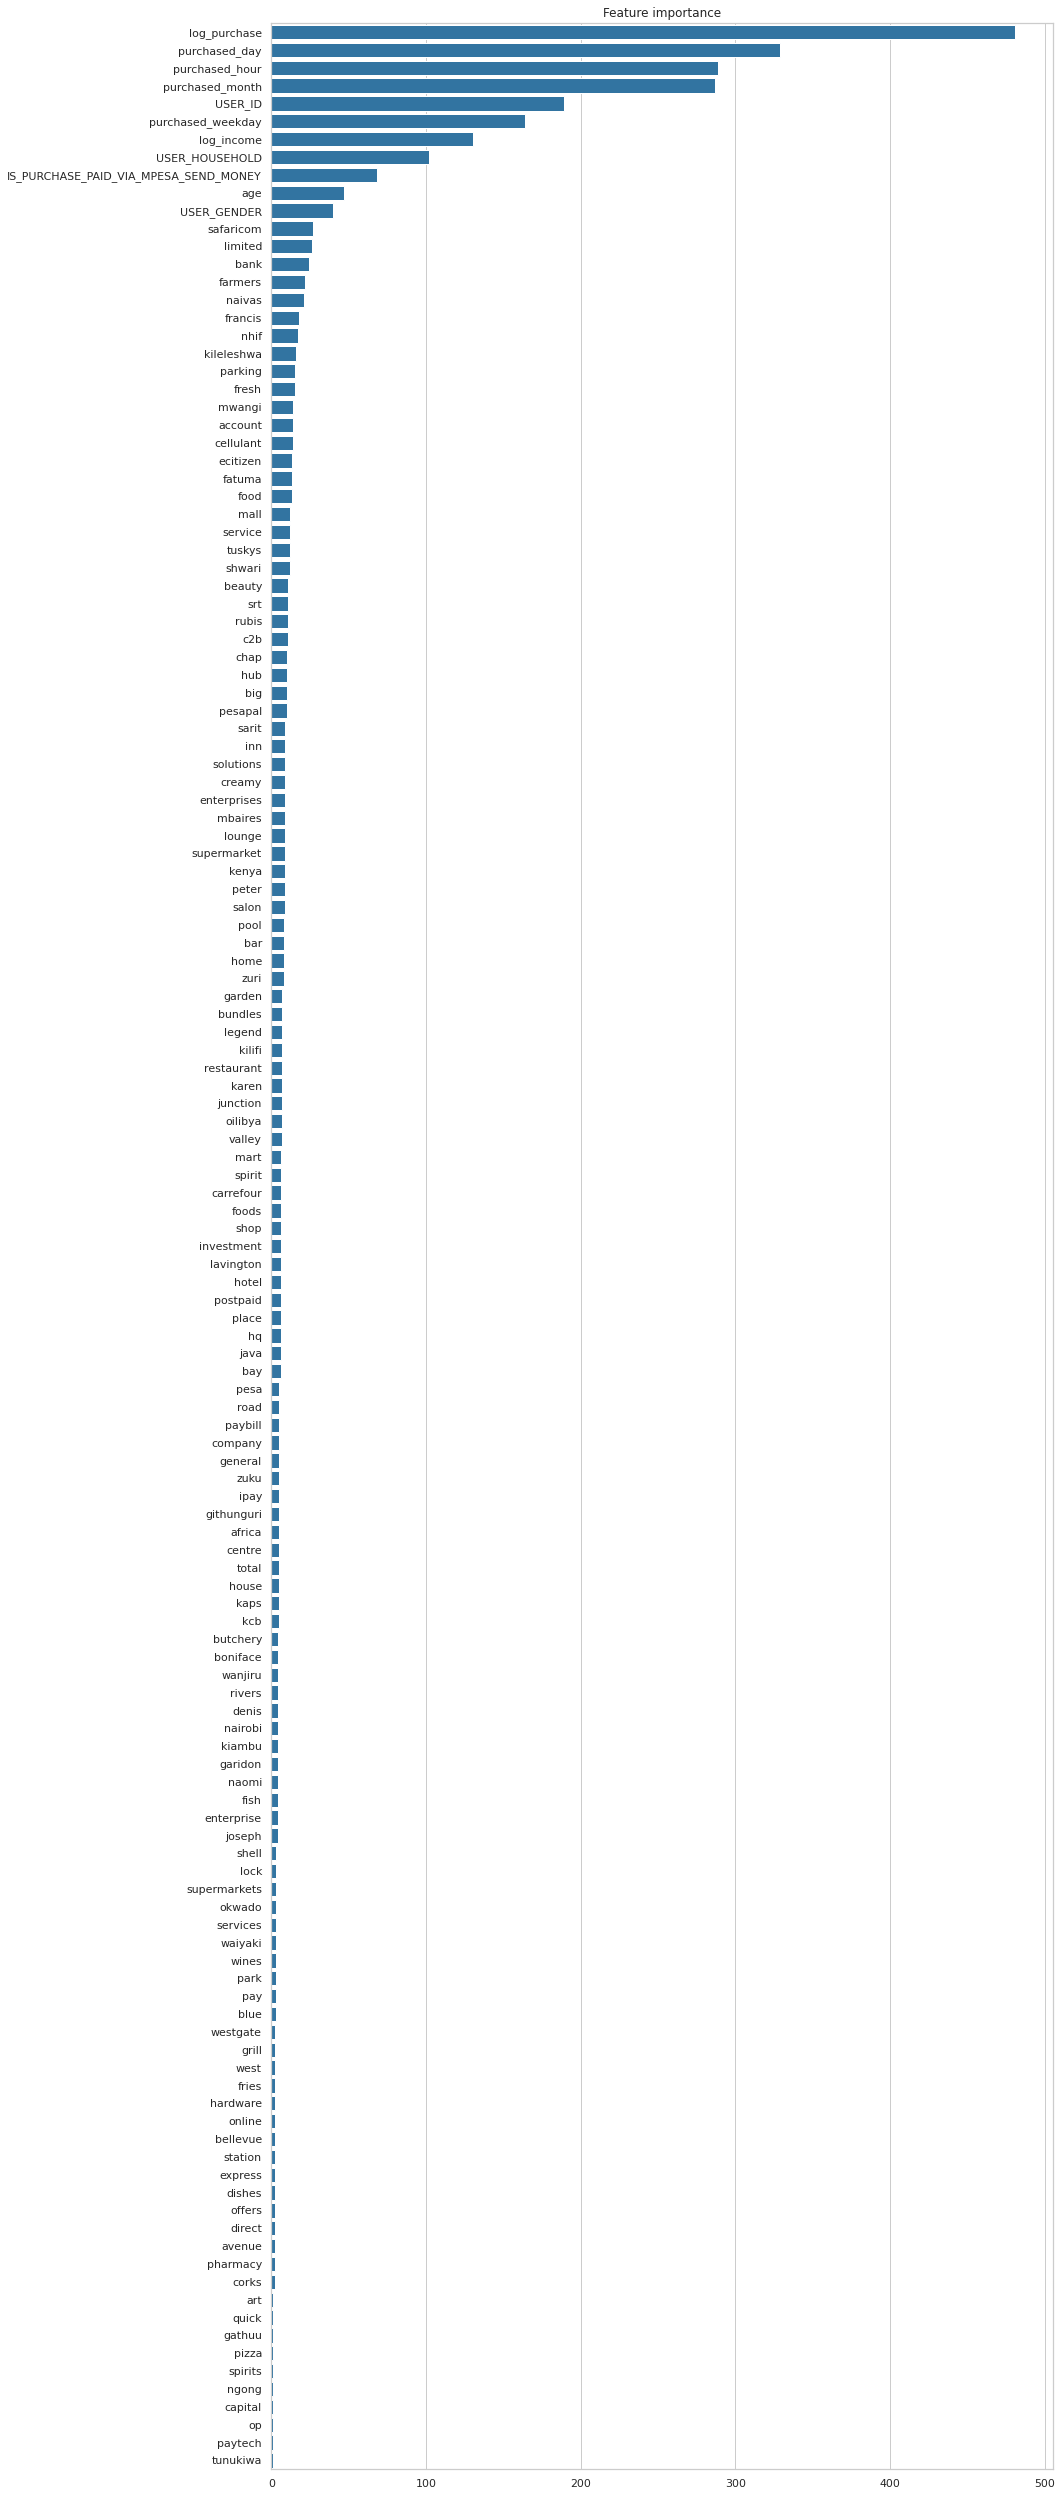

In [16]:
fig, ax = plt.subplots(figsize=(14, len(important) // 3))

sns.barplot(x=important.values, y=important.index, ax=ax, color="tab:blue")
ax.set_title("Feature importance")
plt.show()